In [1]:
include("./src/Chaos.jl")

Main.Chaos

In [2]:
using .Chaos
using Combinatorics
using LinearAlgebra
using LaTeXStrings
using Plots
using Statistics

pyplot()

Plots.PyPlotBackend()

In [3]:
Na = 60; # number of atoms
Ls = 3; # number of wells

### The particle conserved basis

In [4]:
Hbs = integer_partition(N=Na, L=Ls);

In [5]:
Lb = length(Hbs) # the dimension of the Hilbert space

1891

In [6]:
Lb_shouldbe = binomial(Na+Ls-1, Na)

1891

### The hopping Hamiltonian

In [7]:
HLs = zeros(Float64, Lb, Lb)
for i in 1:Ls-1
    HLs += hopping_pair(m=i, Na=Na, Hbs=Hbs)
end

In [8]:
Hhop = HLs + HLs';

### The onsite interaction

In [9]:
Honsite = zeros(Float64, Lb, Lb);

In [10]:
for j in 1:Lb
    for k in 1:Lb
        if j == k
            sum = 0
            for l in 1:Ls
                sum += Hbs[j][l]^2 - Hbs[j][l]
            end
            Honsite[j,k] += sum
        end
    end
end

### The tilt potential

In [11]:
function Htit(γ::Float64)
    Htit = zeros(Float64, Lb, Lb)
    for j in 1:Lb
        for k in 1:Lb
            if j == k
                for l in 1:Ls
                    Htit[j,k] += -(l-(Ls-1))*γ*Hbs[j][l]
                end
            end

        end
    end
    return Htit
end

Htit (generic function with 1 method)

### Soft-core interactions

In [12]:
Λ(delta::Int64, d::Float64, C6::Float64, R::Float64) = C6 / ((delta)^6*d^6 + R^6)

Λ (generic function with 1 method)

In [13]:
# Here 'd' is the lattice constant.
function Hsc(d::Float64, C6::Float64, R::Float64)
    Hsc = zeros(Float64, Lb, Lb)
    for j in 1:Lb
        for k in 1:Lb
            if j == k
                for l in 1:Ls
                    for m in 1:Ls
                        if l-m == 0
                            Hsc[j,k] += Λ(0,d,C6,R)*Hbs[j][l]*Hbs[j][m]
                        elseif abs(m-l) == 1
                            Hsc[j,k] += Λ(1,d,C6,R)*Hbs[j][l]*Hbs[j][m]
                        elseif abs(m-l) == 2
                            Hsc[j,k] += Λ(2,d,C6,R)*Hbs[j][l]*Hbs[j][m]
                        else
                            continue
                        end
                    end
                end
            end
        end
    end
    return Hsc
end

Hsc (generic function with 1 method)

### Parameters we gonna use for reproducing Gary's results

In [14]:
Λ(1, 1.5, 100.0, 3.0)

0.13506383876754247

In [15]:
Λ(2, 1.5, 100.0, 3.0)

0.06858710562414266

In [16]:
Λ(0, 1.5, 100.0, 3.0)

0.13717421124828533

### Construction of the full Hamiltonian

In [17]:
function Htot(;γ::Float64, J::Float64, g::Float64, d::Float64, C6::Float64, R::Float64)
    Htot = Htit(γ) - J*Hhop + (g/2)*Honsite + (1/2)*Hsc(d,C6,R)
    return Htot
end
    

Htot (generic function with 1 method)

### Plot with respect to $\gamma$
Here we will fix all parameters in function $\textbf{Htot}$ listed above except $\gamma$. Like we've stated as above, with all the parameters fixed, we have $\Lambda_0=0.137$, $\Lambda_1\approx 0.135$ and $\Lambda_2\approx 0.069$ so that we approximately have $\Lambda_1\approx 2\Lambda_2$ (i.e., Gary's assumption).

In [18]:
J = 1.0
g = -0.137
d = 1.5
C6 = 100.0
R = 3.0
#gammas = -5.0:0.1:5.0
gammas = 0:0.2:10
eigs = zeros(Float64, Lb, length(gammas));

# i1 = 1
# for gamma in gammas
#     eigs[:,i1] = eigvals(Htot(γ=gamma, J=J, g=g, d=d, C6=C6, R=R))
#     i1 += 1
# end

In [19]:
# p1 = plot(xlab=L"$\gamma$", ylab=L"$\epsilon$", legend=false);

In [20]:
# for i in 1:Lb
#     plot!(p1, gammas, eigs[i,:])
# end

In [21]:
# p1

### Level spacing distributions
Here we will apply eigenvalue unfolding onto eigenvalues.

In [22]:
# In our case, we take average every 7 levels, we drop (7-1)/2 spacings at either end.
v = 5;

# This is defined for later convenience.
f(x) = exp(-x);
ff(x) = (π*x/2)*exp(-π*x^2/4);

#### Change $\gamma$
Here we will vary $\gamma$ to see if the chaos will be trigered.
#### Case 1. $\gamma=0.0$

In [23]:
eigs1 = eigvals(Htot(γ=0.0, J=J, g=g, d=d, C6=C6, R=R));

In [24]:
diffs1 = [eigs1[i+1]-eigs1[i] for i in 1:length(eigs1)-1];

In [25]:
index1 = Int((v-1)/2)
index2 = length(diffs1)-index1
diffs1_dropped = diffs1[index1:index2];

In [26]:
new_diffs1 = []
for i in 1:length(diffs1_dropped)
    drop_index = Int((v-1)/2)
    if i-drop_index>0 && i+drop_index<=length(diffs1_dropped)
        append!(new_diffs1, diffs1_dropped[i]/average_spacing(diffs1_dropped, i, v))
    end
end

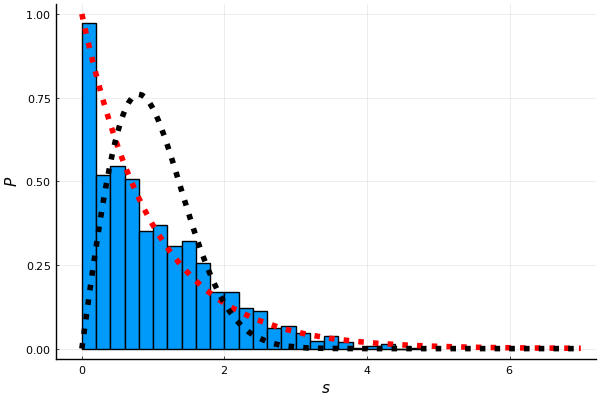

In [27]:
p2 = plot(xlab=L"$s$", ylab=L"$P$", legend=false)
histogram!(p2, new_diffs1, bins=:auto, normed=true)
plot!(p2, f, 0, 7, linestyle=:dot, linewidth=4, color=:red)
plot!(p2, ff, 0, 7, linestyle=:dot, linewidth=4, color=:black)

#### Case 2. $\gamma=2.5$

In [28]:
eigs2 = eigvals(Htot(γ=2.5, J=J, g=g, d=d, C6=C6, R=R));

In [29]:
diffs2 = [eigs2[i+1]-eigs2[i] for i in 1:length(eigs2)-1];

In [30]:
index12 = Int((v-1)/2)
index22 = length(diffs2)-index12
diffs2_dropped = diffs2[index12:index22];

In [31]:
new_diffs2 = []
for i in 1:length(diffs2_dropped)
    drop_index = Int((v-1)/2)
    if i-drop_index>0 && i+drop_index<=length(diffs2_dropped)
        append!(new_diffs2, diffs2_dropped[i]/average_spacing(diffs2_dropped, i, v))
    end
end

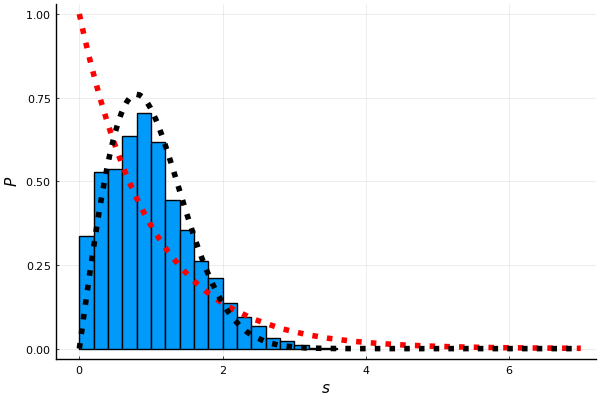

In [32]:
p3 = plot(xlab=L"$s$", ylab=L"$P$", legend=false)
histogram!(p3, new_diffs2, bins=:auto, normed=true)
plot!(p3, f, 0, 7, linestyle=:dot, linewidth=4, color=:red)
plot!(p3, ff, 0, 7, linestyle=:dot, linewidth=4, color=:black)

#### Case 3. $\gamma=10$

In [33]:
eigs3 = eigvals(Htot(γ=10.0, J=J, g=g, d=d, C6=C6, R=R));

In [34]:
diffs3 = [eigs3[i+1]-eigs3[i] for i in 1:length(eigs3)-1];

In [35]:
index13 = Int((v-1)/2)
index23 = length(diffs3)-index13
diffs3_dropped = diffs3[index13:index23];

In [36]:
new_diffs3 = []
for i in 1:length(diffs3_dropped)
    drop_index = Int((v-1)/2)
    if i-drop_index>0 && i+drop_index<=length(diffs3_dropped)
        append!(new_diffs3, diffs3_dropped[i]/average_spacing(diffs3_dropped, i, v))
    end
end

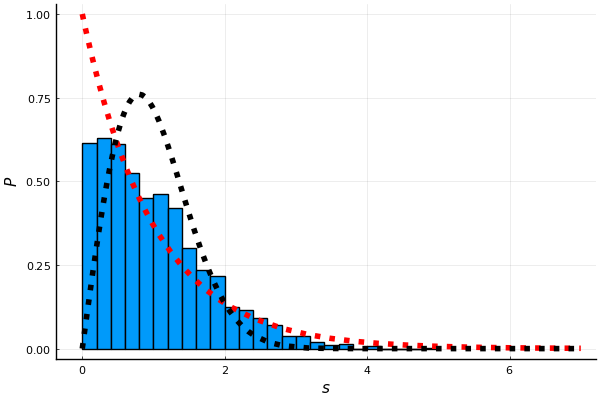

In [37]:
p4 = plot(xlab=L"$s$", ylab=L"$P$", legend=false)
histogram!(p4, new_diffs3, bins=:auto, normed=true)
plot!(p4, f, 0, 7, linestyle=:dot, linewidth=4, color=:red)
plot!(p4, ff, 0, 7, linestyle=:dot, linewidth=4, color=:black)

### Conclusion of change of $\gamma$
1. As $\gamma$ increases, chaos emerges as the level distritution turns into Wigner distribution.
2. What I found out that if I set $\Lambda_1$ larger than 1, then the nice Wigner distribution as listed here will disappear no matter how I change $\gamma$. I think this is because if the system has strong neareast-neighbour interactions, then such system will self-trap itself in certain state, therefore no matter how I change the tilting potential, I will not change much of the state of the system.

### Entanglement entropy and entanglement spectrum
We will first consider the entanglement spectrum for the ground state of the system. When we try to calculate the reduced density matrix, we will bipartite the system into two subsystems each containing 1 and 2 sites and we will trace out the 1 site subsystem.

In [39]:
function EE(; γ::Float64, J::Float64, g::Float64, d::Float64, C6::Float64, R::Float64, Na::Int64)
    vec = eigvecs(Htot(γ=γ, J=J, g=g, d=d, C6=C6, R=R))[:,1]
    rdmat = reduced_density_matrix(state=vec, Na=Na)
    vals = svd(rdmat).S
    EE = -transpose(vals)*log.(vals)
    return EE
end

EE (generic function with 1 method)

In [40]:
function ES(; γ::Float64, J::Float64, d::Float64, C6::Float64, R::Float64, Na::Int64)
    vec = eigvecs(Htot(γ=γ, J=J, g=g, d=d, C6=C6, R=R))[:,1]
    rdmat = reduced_density_matrix(state=vec, Na=Na);
    vals = svd(rdmat).S
    ES = -log.(vals)
    return ES
end

ES (generic function with 1 method)

In [41]:
function evolEE(;H::Matrix{Float64},t::Float64,basis::Vector{Vector{Int64}},init::Vector{Int})
    vec = state_evolution(H=H,t=t,basis=basis,init=init)
    rdmat = reduced_density_matrix(state=vec, Na=Na)
    vals = svd(rdmat).S
    #EE = -transpose(conj(vals).*vals)*log.(conj(vals).*(vals))
    EE = -transpose(vals)*log.(vals)
    return EE
end

evolEE (generic function with 1 method)

In [42]:
function evolfullEE(;H::Matrix{Float64},t::Float64,basis::Vector{Vector{Int64}},init::Vector{Int})
    vec = state_evolution(H=H,t=t,basis=basis,init=init)
    dmat = vec*vec'
    vals = svd(dmat).S
    EE = -transpose(vals)*log.(vals)
    return EE
end

evolfullEE (generic function with 1 method)

In [43]:
H0 = Htot(γ=0.0, J=J, g=g, d=d, C6=C6, R=R);
H1 = Htot(γ=1.0, J=J, g=g, d=d, C6=C6, R=R);
H4 = Htot(γ=4.0, J=J, g=g, d=d, C6=C6, R=R);
H10 = Htot(γ=10.0, J=J, g=g, d=d, C6=C6, R=R);

In [44]:
EE0 = EE(γ=0.0, J=J, g=g, d=d, C6=C6, R=R, Na=Na);
EE1 = EE(γ=1.0, J=J, g=g, d=d, C6=C6, R=R, Na=Na);
EE4 = EE(γ=4.0, J=J, g=g, d=d, C6=C6, R=R, Na=Na);
EE10 = EE(γ=10.0, J=J, g=g, d=d, C6=C6, R=R, Na=Na);

In [45]:
ts = 0.1:0.1:5.0;
evolEE0s = [evolEE(H=H0,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts];
evolEE1s = [evolEE(H=H1,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts];
evolEE4s = [evolEE(H=H4,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts];
evolEE10s = [evolEE(H=H10,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts];
print("Done")

Done

In [46]:
# t1s = 0.1:0.2:5
# evolfullEEs = [evolfullEE(H=H0,t=t,basis=Hbs,init=vec([20 20 20])) for t in t1s]

In [47]:
# plot(evolfullEEs)

In [48]:
prepend!(evolEE0s,EE0);
prepend!(evolEE1s,EE1);
prepend!(evolEE4s,EE4);
prepend!(evolEE10s,EE10);

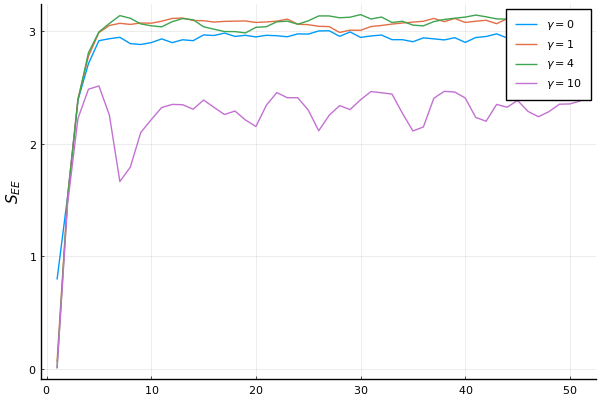

In [49]:
eplot = plot(ylab=L"$S_{EE}$")
plot!(eplot, evolEE0s, label=L"$\gamma=0$")
plot!(eplot, evolEE1s, label=L"$\gamma=1$")
plot!(eplot, evolEE4s, label=L"$\gamma=4$")
plot!(eplot, evolEE10s, label=L"$\gamma=10$")

We will next study how the average entanglement entropy reacts to $\gamma$. The logic is I will evolve reduced density matrices at different $\gamma$'s, then calculate the average of EE's.

In [50]:
gammas = 0.0:1:10
ts1 = 0.1:0.3:5.0
aveEEs = zeros(Float64, 1, length(gammas))
@time for i in 1:length(gammas)
    gamma = gammas[i]
    H = Htot(γ=gamma, J=J, g=g, d=d, C6=C6, R=R)
    evolEEs = [evolEE(H=H,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts1]
    len = length(evolEEs)
    drop_rate = 0.2 # we drop the first 20% of data
    left_num = Int(floor(drop_rate*len))
    aveEEs[i] = mean(evolEEs[left_num:len])   
    display(aveEEs)
end

1×11 Matrix{Float64}:
 2.94613  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  3.12205  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  3.12205  3.11962  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  3.12205  3.11962  3.09687  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  3.12205  3.11962  …  3.03631  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  3.12205  3.11962  …  3.03631  2.938  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  3.12205  3.11962  …  2.938  2.77983  0.0  0.0  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  3.12205  3.11962  …  2.938  2.77983  2.63529  0.0  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  3.12205  3.11962  …  2.77983  2.63529  2.44711  0.0

1×11 Matrix{Float64}:
 2.94613  3.08001  3.12205  3.11962  …  2.77983  2.63529  2.44711  2.257

354.041003 seconds (199.79 M allocations: 71.557 GiB, 0.80% gc time, 0.16% compilation time)


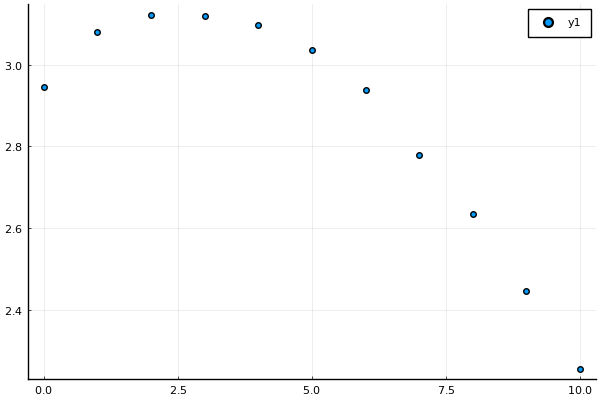

In [51]:
scatter(gammas, aveEEs')

## The quench dynamics
We here will study here how a system in zero tilting potential will behave under a quench to higher tilting potential (i.e., chaotic region or non-chaotic region). The initial state is considered as the ground state when $\gamma=0$, then at $t=0$ we will change $\gamma$ to 4 to study the quench dynamics.

In [52]:
H = Htot(γ=0.0, J=J, g=g, d=d, C6=C6, R=R);

In [53]:
state_evolution(H=Htot(γ=2.5, J=J, g=g, d=d, C6=C6, R=R),t=0.5,basis=Hbs,init=vec([20 20 20]));

## Shannon Entropy

In [38]:
H = Htot(γ=4.0, J=J, g=g, d=d, C6=C6, R=R);
vals = eigvals(H);
vecs = eigvecs(H);

In [39]:
function α(;m::Int64, t::Float64, vals::Vector{Float64}, vecs::Matrix{Float64}, basis::Vector{Vector{Int64}}, init::Vector{Int64})
    ind = findall(x->x==init, basis)[1]
    Cvec = vecs[m,:]
    α = 0
    for j in 1:length(Cvec)
        pj = conj(vecs[ind,j])
        E_j = vals[j]
        α += pj*exp(-1im*E_j*t)*Cvec[j]
    end
    return α
end
    

α (generic function with 1 method)

In [40]:
function SB(;t::Float64, vals::Vector{Float64}, vecs::Matrix{Float64}, basis::Vector{Vector{Int64}}, init::Vector{Int64})
    SB = 0
    for i in 1:length(vals)
        αm = α(m=i, t=t, vals=vals, vecs=vecs, basis=Hbs, init=init)
        a = αm * conj(αm)
        SB += -a*log(a)
    end
    return SB
end

SB (generic function with 1 method)

In [41]:
ts = 0.1:0.2:5
SBs = zeros(Float64, 1, length(ts))
for i in 1:length(ts)
    SBs[i] = SB(t=ts[i], vals=vals, vecs=vecs, basis=Hbs, init=vec([20 20 20]))
end


In [42]:
p = plot(legend=false);

In [43]:
for i in 1:length(ts)
    scatter!(p, (ts[i], SBs[i]))
end

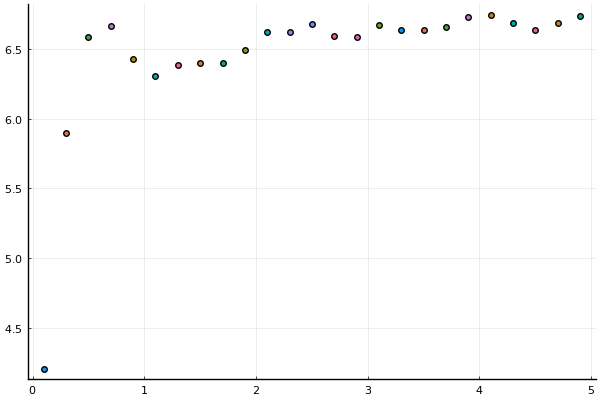

In [44]:
p